# Étape 1 — Chargement et exploration initiale

(116, 10)
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  

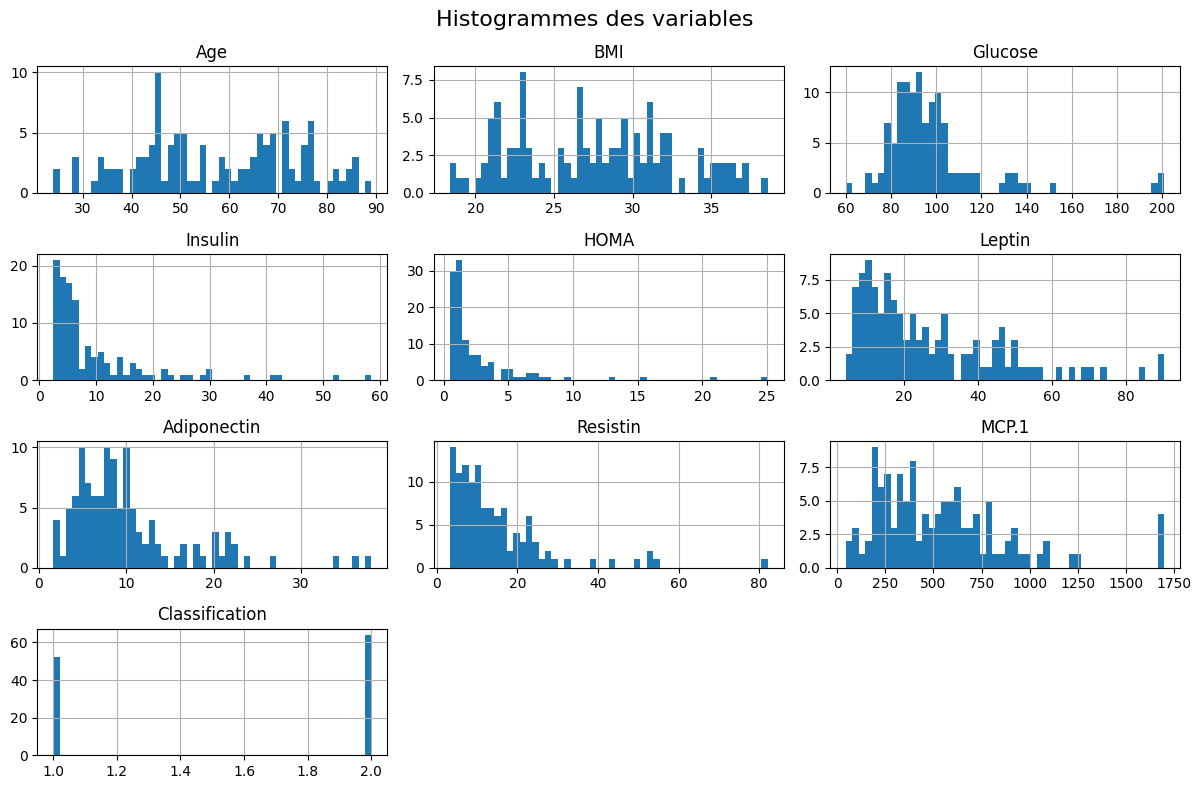

In [1]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
data = pd.read_csv('breast+cancer+coimbra/dataR2.csv')

# Aperçu des données
print(data.shape)
print(data.head())
data.info()

# Liste des variables explicatives
features = data.columns[:-1]
target = 'Classification'

# Histogrammes des variables
data.hist(bins=50, figsize=(12, 8))
plt.suptitle("Histogrammes des variables", fontsize=16)
plt.tight_layout()
plt.show()


# Étape 2 — Split du dataset en train et test


In [2]:
from sklearn.model_selection import train_test_split

# Séparation des features et de la cible
X = data.drop(columns='Classification')
y = data['Classification']

# Split stratifié pour préserver la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Vérification de la forme
print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)


Train : (92, 9) (92,)
Test  : (24, 9) (24,)


# Étape 3 — Visualisation des distributions par classe

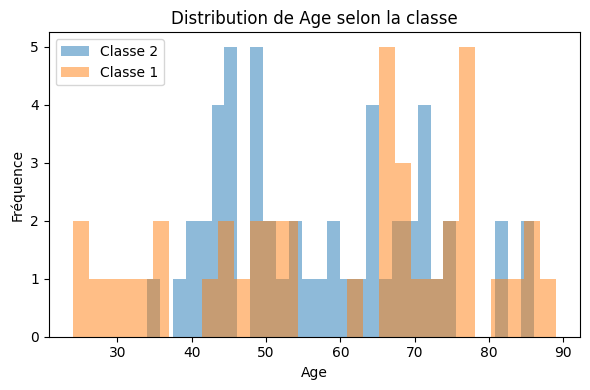

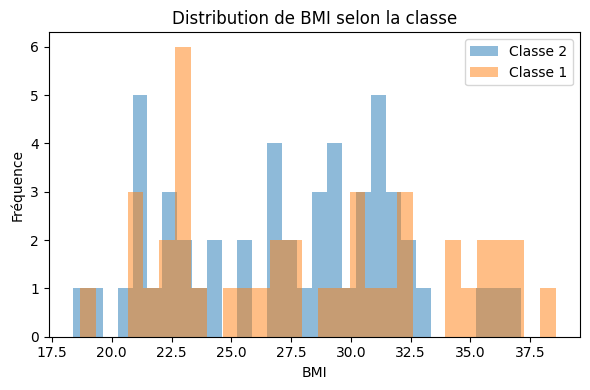

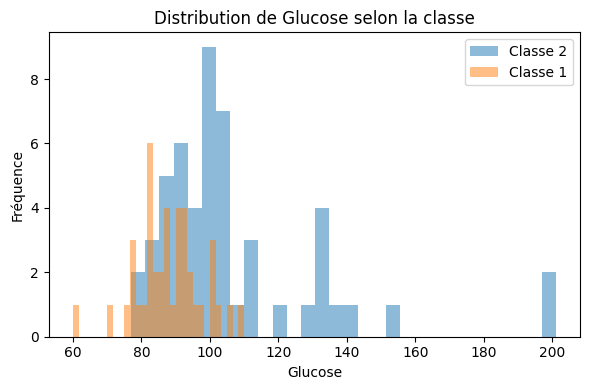

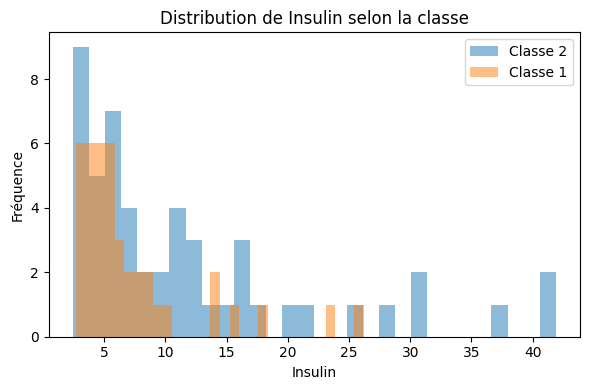

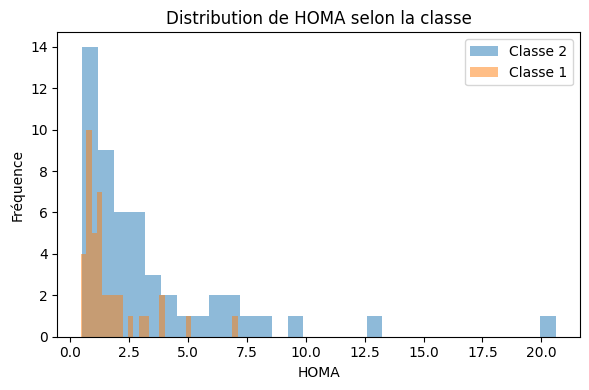

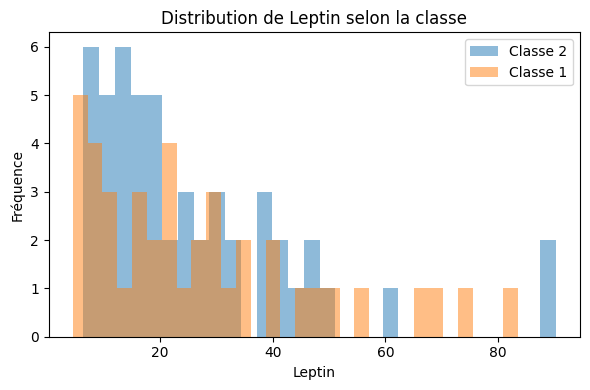

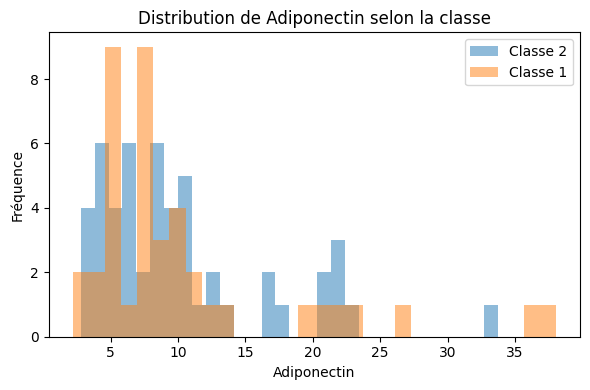

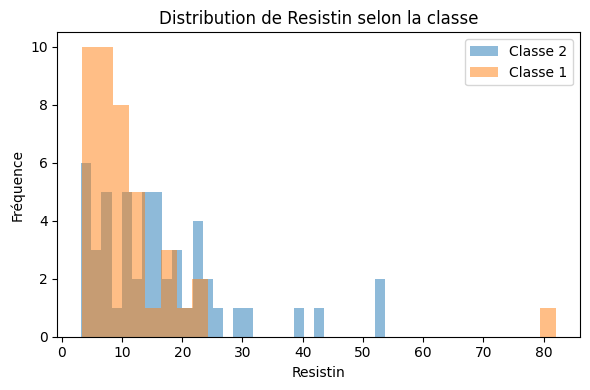

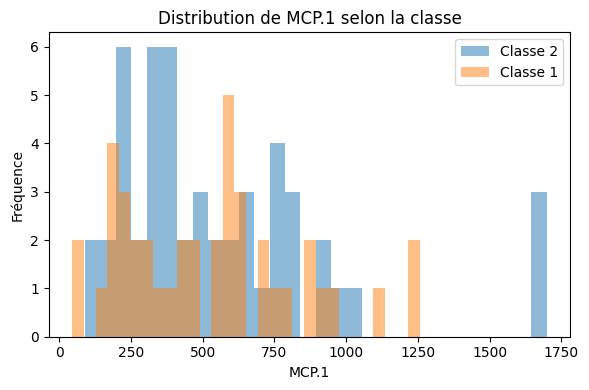

In [3]:
# Fusion temporaire pour affichage
train_data = X_train.copy()
train_data['Classification'] = y_train

# Histogrammes par classe pour chaque variable
for col in X_train.columns:
    plt.figure(figsize=(6, 4))
    for class_label in y_train.unique():
        plt.hist(train_data[train_data['Classification'] == class_label][col],
                 bins=30, alpha=0.5, label=f'Classe {class_label}')
    plt.title(f"Distribution de {col} selon la classe")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Étape 4 — Matrice de corrélation et scatter matrix (train uniquement)

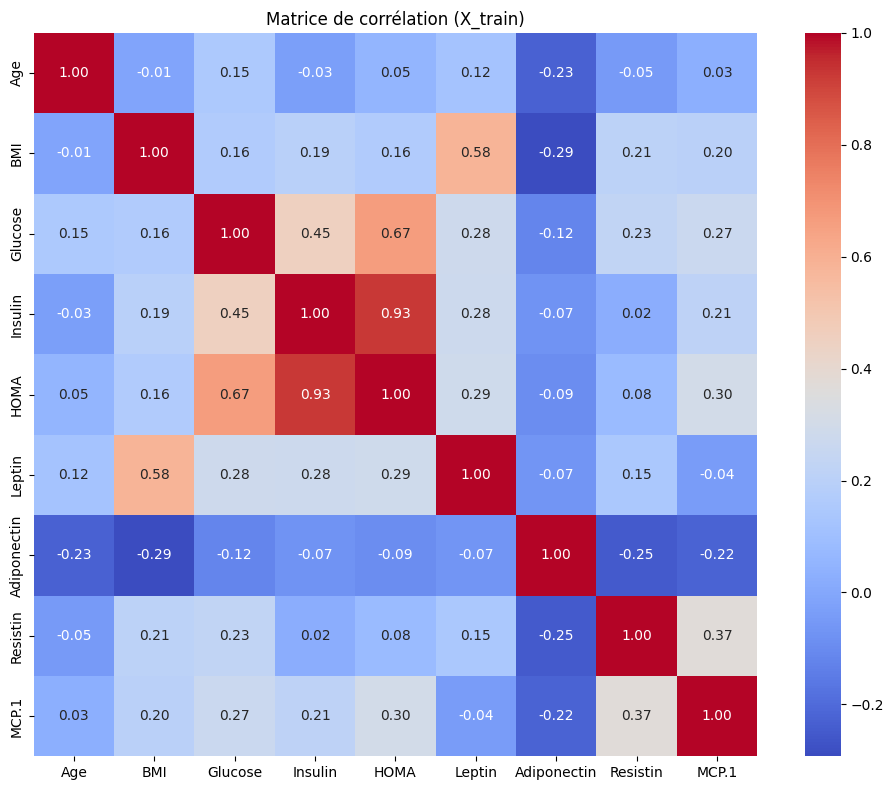

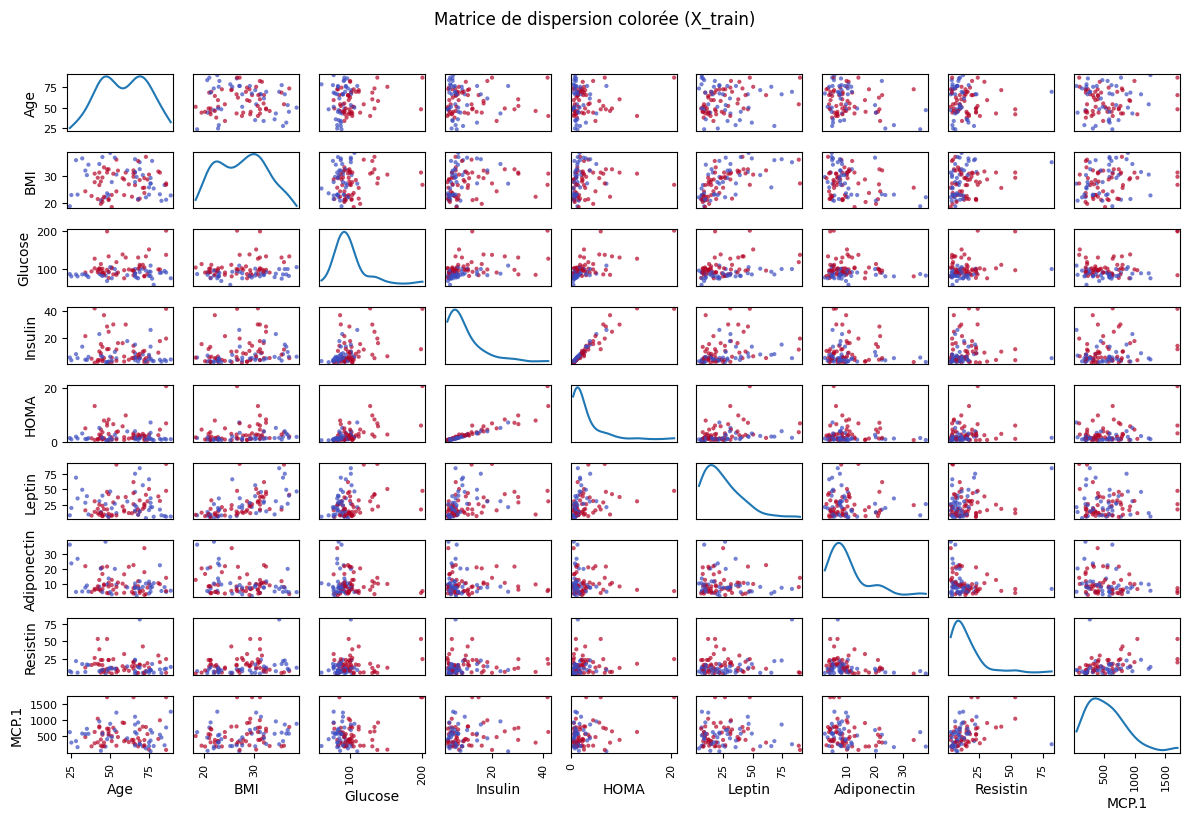

In [5]:
from pandas.plotting import scatter_matrix
# Matrice de corrélation (sur les données d'entraînement)
corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation (X_train)")
plt.tight_layout()
plt.show()

# DataFrame combiné pour visualisation colorée
X_train_visu = X_train.copy()
X_train_visu['Classification'] = y_train.values

# Scatter matrix colorée
scatter_matrix(X_train_visu.drop(columns='Classification'),
               figsize=(12, 8),
               diagonal='kde',
               c=X_train_visu['Classification'],
               cmap='coolwarm',
               alpha=0.7)
plt.suptitle("Matrice de dispersion colorée (X_train)", y=1.02)
plt.tight_layout()
plt.show()



# Étape 5 — Transformation logarithmique 

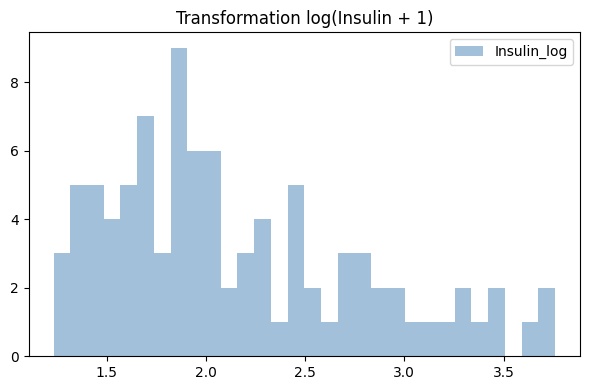

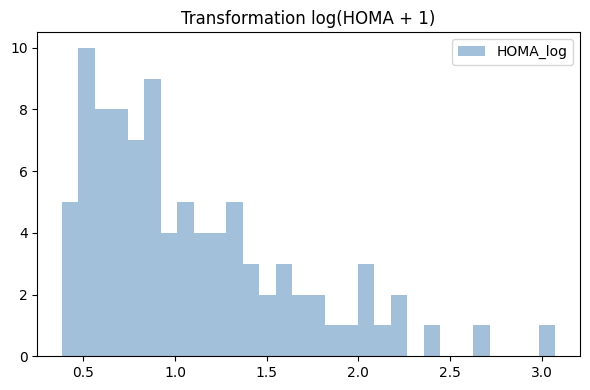

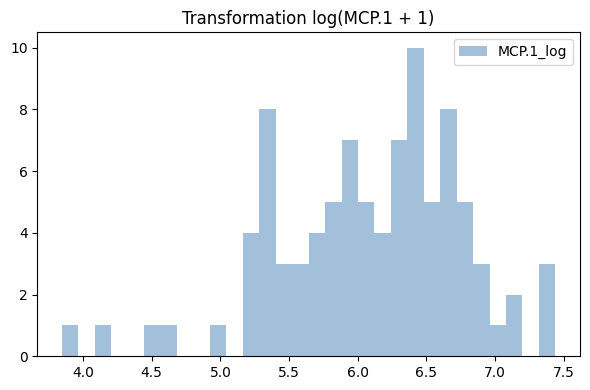

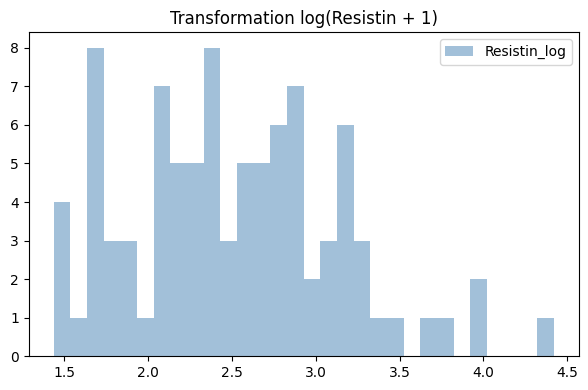

In [8]:
# Variables à transformer (forte asymétrie identifiée précédemment) 
variables_log = ['Insulin', 'HOMA', 'MCP.1', 'Resistin']

# Copie de X_train pour transformation
X_train_transformed = X_train.copy()

# Transformation log(x + 1)
for col in variables_log:
    X_train_transformed[col + '_log'] = np.log1p(X_train_transformed[col])
    
# Suppression des colonnes d'origine (optionnelle mais recommandée)
X_train_transformed = X_train_transformed.drop(columns=variables_log)

# Mise à jour de la liste des variables
features = X_train_transformed.columns.tolist()

for col in variables_log:
    plt.figure(figsize=(6, 4))
    plt.hist(np.log1p(X_train[col]), bins=30, alpha=0.5, label=f'{col}_log', color='steelblue')
    plt.title(f"Transformation log({col} + 1)")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Étape 6 — Standardisation (StandardScaler)

In [9]:
from sklearn.preprocessing import StandardScaler

# Initialisation du scaler
scaler = StandardScaler()

# Entraînement du scaler sur le jeu transformé
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_transformed),
    columns=X_train_transformed.columns,
    index=X_train_transformed.index
)

X_train_scaled.describe().T[['mean', 'std']]


,mean,std
Age,-2.003229e-16,1.005479
BMI,-6.389816e-16,1.005479
Glucose,8.326673e-17,1.005479
Leptin,-5.068409e-17,1.005479
Adiponectin,8.839547e-17,1.005479
Insulin_log,-1.194697e-16,1.005479
HOMA_log,-2.256649e-16,1.005479
MCP.1_log,1.128324e-15,1.005479
Resistin_log,6.552729e-16,1.005479


# Étape 7 — Préparation de X_test

In [10]:
# Copie de X_test
X_test_transformed = X_test.copy()

# Appliquer les mêmes log-transforms
for col in variables_log:
    X_test_transformed[col + '_log'] = np.log1p(X_test_transformed[col])

# Supprimer les colonnes originales
X_test_transformed = X_test_transformed.drop(columns=variables_log)

# Standardiser avec le scaler déjà entraîné sur X_train
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_transformed),
    columns=X_test_transformed.columns,
    index=X_test_transformed.index
)

assert list(X_train_scaled.columns) == list(X_test_scaled.columns), "Mismatch between train and test columns"


# Étape 8 — Modélisation avec LogisticRegression

In [11]:
from sklearn.linear_model import LogisticRegression

# Initialisation du modèle
logreg = LogisticRegression(random_state=42)

# Entraînement sur les données standardisées
logreg.fit(X_train_scaled, y_train)

# Prédictions sur le test
y_pred = logreg.predict(X_test_scaled)


# Étape 9 — Évaluation du modèle

In [12]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.3f}")

# F1-score (binaire par défaut)
f1 = f1_score(y_test, y_pred)
print(f"F1-score : {f1:.3f}")

# Rapport complet
print("\nClassification Report :")
print(classification_report(y_test, y_pred))


Accuracy : 0.750
F1-score : 0.750

Classification Report :
              precision    recall  f1-score   support

           1       0.69      0.82      0.75        11
           2       0.82      0.69      0.75        13

    accuracy                           0.75        24
   macro avg       0.76      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



# Étape 10 — Validation croisée (cross-validation)

In [13]:
from sklearn.model_selection import cross_val_score

# Initialisation du modèle
logreg = LogisticRegression(random_state=42)

# Validation croisée avec scoring F1
f1_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='f1')
acc_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Résumé
print("Validation croisée (5 folds)")
print(f"F1-score moyen     : {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
print(f"Accuracy moyen     : {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")


Validation croisée (5 folds)
F1-score moyen     : 0.749 ± 0.119
Accuracy moyen     : 0.784 ± 0.087


In [ ]:
# Créer une copie de X_test pour transformation
X_test_transformed = X_test.copy()

# Appliquer les mêmes log-transforms
for col in variables_log:
    X_test_transformed[col + '_log'] = np.log1p(X_test_transformed[col])

# Supprimer les anciennes colonnes
X_test_transformed = X_test_transformed.drop(columns=[col for col in variables_log if col in X_test_transformed.columns])

# ✅ Supprimer aussi les variables non conservées dans le train
X_test_transformed = X_test_transformed.drop(columns=['Adiponectin', 'Leptin'])

# Standardiser
X_test_scaled = pd.DataFrame(scaler.transform(X_test_transformed),
                             columns=X_test_transformed.columns,
                             index=X_test_transformed.index)

# Prédiction
y_pred = mod_logReg.predict(X_test_scaled)